In [53]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline


# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [54]:
dataset = MNIST(root='data/',download = True, transform=ToTensor())

In [55]:
len(dataset)

60000

In [56]:
dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

Let's look at a couple of images from the dataset. The images are converted to PyTorch tensors with the shape 1x28x28 (the dimensions represent color channels, width and height). We can use plt.imshow to display the images. However, plt.imshow expects channels to be last dimension in an image tensor, so we use the permute method to reorder the dimensions of the image.

Shape: torch.Size([28, 28])
label: 5


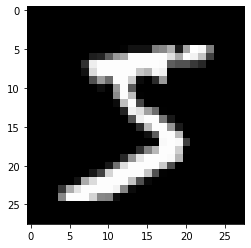

In [57]:
image, label = dataset[0]
print("Shape:", image[0].shape)
plt.imshow(image[0], cmap = 'gray' )
print("label:", label)

In [58]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [59]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True,num_workers = 4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


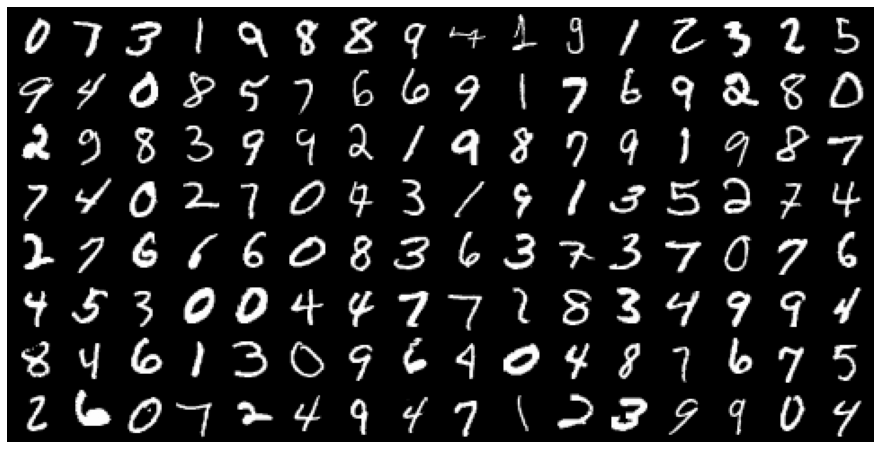

In [60]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

# **Hidden Layer, activation fn and non-linearity**

In [61]:
for images, labels in train_loader:
  print(images.shape)
  inputs = images.reshape(-1,784)
  print(inputs.shape)
  break

torch.Size([128, 1, 28, 28])
torch.Size([128, 784])


In [62]:
input_size =  inputs.shape[-1]
hidden_size = 32

In [63]:
layer1 = nn.Linear(input_size, hidden_size)

In [64]:
inputs.shape

torch.Size([128, 784])

In [65]:
layer1_output = layer1(inputs)
layer1_output.shape

torch.Size([128, 32])

The image vectors of size 784 are transformed into intermediate output vectors of length 32 by performing a matrix multiplication of inputs matrix with the transposed weights matrix of layer1 and adding the bias. We can verify this using torch.allclose.

In [66]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [67]:
torch.allclose(layer1_output,layer1_outputs_direct, 1e-3)

True

hus, layer1_outputs and inputs have a linear relationship, i.e., each element of layer_outputs is a weighted sum of elements from inputs. Thus, even as we train the model and modify the weights, layer1 can only capture linear relationships between inputs and outputs.



Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula relu(x) = max(0,x) i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function.We can use the F.relu method to apply ReLU to the elements of a tensor.

In [68]:
F.relu(torch.tensor([[-1.0,2.0,3.0],
                    [2.5,1.0,-7]]))

tensor([[0.0000, 2.0000, 3.0000],
        [2.5000, 1.0000, 0.0000]])

In [69]:
layer1_output.shape

torch.Size([128, 32])

In [70]:
relu_output = F.relu(layer1_output)
relu_output.shape

torch.Size([128, 32])

In [71]:
torch.min(layer1_output)

tensor(-0.9055, grad_fn=<MinBackward1>)

In [72]:
torch.min(relu_output)

tensor(0., grad_fn=<MinBackward1>)

In [73]:
output_size = 10
layer2= nn.Linear(hidden_size, output_size)
layer2_output = layer2(relu_output)
layer2_output.shape

torch.Size([128, 10])

In [74]:
inputs.shape

torch.Size([128, 784])

In [75]:
relu_output.shape

torch.Size([128, 32])

In [76]:
layer2_output.shape

torch.Size([128, 10])

As expected, layer2_outputs contains a batch of vectors of size 10. We can now use this output to compute the loss using F.cross_entropy and adjust the weights of layer1 and layer2 using gradient descent.

In [77]:
F.cross_entropy(layer2_output, labels)

tensor(2.3460, grad_fn=<NllLossBackward0>)

In [78]:
# expanded version ogf layer2
outputs = (F.relu(inputs @ layer1.weight.t()+layer1.bias)) @ layer2.weight.t()+layer2.bias

In [79]:
torch.allclose(outputs, layer2_output, 1e-3)

True

Note that outputs and inputs do not have a linear relationship due to the non-linear activation function F.relu. As we train the model and adjust the weights of layer1 and layer2, we can now capture non-linear relationships between the images and their labels. In other words, introducing non-linearity makes the model more powerful and versatile. Also, since hidden_size does not depend on the dimensions of the inputs or outputs, we vary it to increase the number of parameters within the model. We can also introduce new hidden layers and apply the same non-linear activation after each hidden layer.

The model we just created is called a neural network. A deep neural network is simply a neural network with one or more hidden layers. In fact, the Universal Approximation Theorem states that a sufficiently large & deep neural network can compute any arbitrary function i.e. it can learn rich and complex non-linear relationships between inputs and targets. Here are some examples:

Identifying if an image contains a cat or a dog (or something else)
Identifying the genre of a song using a 10-second sample
Classifying movie reviews as positive or negative based on their content
Navigating self-driving cars using a video feed of the road
Translating sentences from English to French (and hundreds of other languages)
Converting a speech recording to text and vice versa
And many more...
It's hard to imagine how the simple process of multiplying inputs with randomly initialized matrices, applying non-linear activations, and adjusting weights repeatedly using gradient descent can yield such astounding results. Deep learning models often contain millions of parameters, which can together capture far more complex relationships than the human brain can comprehend.

If we hadn't included a non-linear activation between the two linear layers, the final relationship between inputs and outputs would still be linear. 

In [80]:
# without non-linear act. fn
outputs = (inputs @ layer1.weight.t()+layer1.bias) @ layer2.weight.t()+layer2.bias

In [81]:
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight 
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [82]:
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [83]:
torch.allclose(outputs, outputs3, 1e-3)

True

# Training Model

In [84]:
class MnistModel(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
      super().__init__()
      self.linear1 = nn.Linear(in_size, hidden_size)
      self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
      xb = xb.view(xb.size(0), -1)
      out = self.linear1(xb)
      out = F.relu(out)
      out = self.linear2(out)
      return out

    def training_step(self, batch): # will take batch and return loss
      images, labels = batch
      out = self(image)
      loss = F.cross_entropy(out, labels)
      return loss

    def validation_step(self, batch): # will take batch and return val loss and val acc
      images, labels = batch
      out = self(images)
      loss = F.cross_entropy(out, labels)
      acc = accuracy(out, labels)
      return {'val_loss':loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
      

In [85]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [86]:
input_size = 784
hidden_size = 32 # hyperparameter
num_classes = 10

In [87]:
model = MnistModel(input_size, hidden_size, out_size = num_classes)

In [88]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [89]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3458213806152344
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0462, -0.2004,  0.0165,  0.1651, -0.1145, -0.0131,  0.1824, -0.0524,
          0.0740, -0.0449],
        [ 0.0294, -0.1633,  0.0869,  0.0850, -0.1512, -0.0947,  0.1744,  0.0138,
          0.0380, -0.0069]])


# Using GPU

As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores optimized for performing expensive matrix operations on floating-point numbers quickly, making them ideal for training deep neural networks. You can use GPUs for free on Google Colab and Kaggle or rent GPU-powered machines on services like Google Cloud Platform, Amazon Web Services, and Paperspace.

We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using torch.cuda.is_available.

In [90]:
torch.cuda.is_available()

False

In [91]:
from torch.cuda import is_available
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [92]:
device = get_default_device()
device

device(type='cpu')

In [93]:
# a fn that can move data and model to a choosen device
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [94]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cpu


In [95]:
'''
Finally, we define a DeviceDataLoader class to wrap our existing data loaders and move batches of data to the selected device. 
Interestingly, we don't need to extend an existing class to create a PyTorch datal oader. 
All we need is an __iter__ method to retrieve batches of data and an __len__ method to get the number of batches.
'''

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [96]:
# The yield keyword in Python is used to create a generator function that can be used within a for loop.
def some_numbers():
    yield 10
    yield 20
    yield 30

for value in some_numbers():
    print(value)

10
20
30


In [97]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [98]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cpu
yb: tensor([5, 0, 6, 2, 7, 7, 2, 3, 1, 8, 1, 0, 0, 2, 1, 2, 9, 9, 2, 4, 8, 5, 8, 9,
        1, 7, 6, 4, 0, 8, 6, 5, 2, 3, 0, 2, 6, 8, 3, 5, 0, 0, 4, 0, 4, 3, 4, 1,
        9, 8, 9, 7, 8, 6, 6, 6, 8, 3, 6, 6, 4, 7, 2, 3, 8, 0, 1, 9, 0, 0, 4, 9,
        4, 8, 3, 4, 5, 4, 2, 3, 3, 0, 5, 1, 9, 2, 0, 5, 4, 9, 6, 7, 7, 5, 5, 6,
        2, 0, 4, 5, 0, 5, 8, 3, 3, 3, 3, 2, 9, 3, 1, 1, 6, 4, 3, 6, 4, 9, 2, 0,
        1, 1, 5, 5, 9, 7, 0, 1])


## **Training a model using GPU**

In [99]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the to_device function to move the model's parameters to the right device.

In [100]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)


In [101]:
to_device(model, device) # error

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [102]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.296454429626465, 'val_acc': 0.10779272019863129}]

In [103]:
history += fit(5, 0.5, model, train_loader, val_loader)

ValueError: ignored